In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

print("✅ Libraries imported!")


# ============================================
# LOAD CLEANED DATA
# ============================================
file_path = r"../../data/processed/processed_taxi_cleaned.parquet"

print("📂 Loading cleaned data...")
df = pd.read_parquet(file_path)
print(f"✅ Loaded {len(df):,} trips with {len(df.columns)} columns")
print(f"   Columns: {list(df.columns)}")


✅ Libraries imported!
📂 Loading cleaned data...
✅ Loaded 2,451,103 trips with 22 columns
   Columns: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee', 'cbd_congestion_fee', 'trip_duration_min', 'has_congestion_fee']


In [5]:
# ============================================
# STEP 1: SPEED FEATURES
# ============================================
print("\n" + "="*70)
print("STEP 1: SPEED FEATURES")
print("="*70)

# Average speed in miles per hour
# Formula: distance / (duration_in_minutes / 60) = distance / duration * 60
df['avg_speed_mph'] = df['trip_distance'] / df['trip_duration_min'] * 60

# Cap extreme speeds (above 60 mph is unrealistic in NYC)
df['avg_speed_mph'] = df['avg_speed_mph'].clip(upper=60)

# Handle any NaN or infinite values from division
df['avg_speed_mph'] = df['avg_speed_mph'].replace([np.inf, -np.inf], 0)
df['avg_speed_mph'] = df['avg_speed_mph'].fillna(0)

print("✅ Speed features created:")
print(f"   avg_speed_mph:")
print(f"     Mean:   {df['avg_speed_mph'].mean():.2f} mph")
print(f"     Median: {df['avg_speed_mph'].median():.2f} mph")
print(f"     Min:    {df['avg_speed_mph'].min():.2f} mph")
print(f"     Max:    {df['avg_speed_mph'].max():.2f} mph")


STEP 1: SPEED FEATURES
✅ Speed features created:
   avg_speed_mph:
     Mean:   11.20 mph
     Median: 9.46 mph
     Min:    0.01 mph
     Max:    60.00 mph


In [6]:
# ============================================
# STEP 2: FARE EFFICIENCY FEATURES
# ============================================
print("\n" + "="*70)
print("STEP 2: FARE EFFICIENCY FEATURES")
print("="*70)

# Fare per mile
df['fare_per_mile'] = np.where(
    df['trip_distance'] > 0,
    df['fare_amount'] / df['trip_distance'],
    0
)
# Cap at reasonable value
df['fare_per_mile'] = df['fare_per_mile'].clip(0, 100)

# Total amount per mile
df['total_per_mile'] = np.where(
    df['trip_distance'] > 0,
    df['total_amount'] / df['trip_distance'],
    0
)
df['total_per_mile'] = df['total_per_mile'].clip(0, 150)

print("✅ Fare efficiency features created:")
print(f"   fare_per_mile:  Mean=${df['fare_per_mile'].mean():.2f}, Median=${df['fare_per_mile'].median():.2f}")
print(f"   total_per_mile: Mean=${df['total_per_mile'].mean():.2f}, Median=${df['total_per_mile'].median():.2f}")


STEP 2: FARE EFFICIENCY FEATURES
✅ Fare efficiency features created:
   fare_per_mile:  Mean=$7.93, Median=$7.30
   total_per_mile: Mean=$13.98, Median=$12.37


In [7]:
# ============================================
# STEP 3: PASSENGER FEATURES
# ============================================
print("\n" + "="*70)
print("STEP 3: PASSENGER FEATURES")
print("="*70)

# Check for missing values in passenger_count
missing_passengers = df['passenger_count'].isnull().sum()
print(f"   Missing passenger_count values: {missing_passengers:,}")

# Fill missing values with the mode (most common value = 1)
if missing_passengers > 0:
    mode_value = df['passenger_count'].mode()[0]
    df['passenger_count'] = df['passenger_count'].fillna(mode_value)
    print(f"   ✅ Filled {missing_passengers:,} missing values with mode: {mode_value:.0f}")
else:
    print(f"   ✅ No missing values - already handled in cleaning!")

# Is single passenger? (most common trip type)
df['is_single_passenger'] = (df['passenger_count'] == 1).astype(int)

# Passenger count binned (1=solo, 2=pair, 3+=group)
def bin_passengers(count):
    if count == 1:
        return 'solo'
    elif count == 2:
        return 'pair'
    else:
        return 'group'

df['passenger_count_binned'] = df['passenger_count'].apply(bin_passengers)

print(f"\n✅ Passenger features created:")
print(f"   is_single_passenger: {df['is_single_passenger'].sum():,} ({df['is_single_passenger'].mean()*100:.1f}%)")
print(f"\n   passenger_count_binned distribution:")
print(df['passenger_count_binned'].value_counts().to_string())



STEP 3: PASSENGER FEATURES
   Missing passenger_count values: 0
   ✅ No missing values - already handled in cleaning!

✅ Passenger features created:
   is_single_passenger: 1,982,081 (80.9%)

   passenger_count_binned distribution:
passenger_count_binned
solo     1982081
pair      334070
group     134952


In [8]:
# ============================================
# STEP 4: COST RATIOS
# ============================================
print("\n" + "="*70)
print("STEP 4: COST RATIOS")
print("="*70)

# Tip percentage (tip as % of fare)
df['tip_percentage'] = np.where(
    df['fare_amount'] > 0,
    (df['tip_amount'] / df['fare_amount']) * 100,
    0
)
# Cap at 100% (above that is likely data error)
df['tip_percentage'] = df['tip_percentage'].clip(0, 100)

# Tip to total ratio (tip as % of total amount)
df['tip_to_total_ratio'] = np.where(
    df['total_amount'] > 0,
    (df['tip_amount'] / df['total_amount']) * 100,
    0
)
df['tip_to_total_ratio'] = df['tip_to_total_ratio'].clip(0, 100)

print("✅ Cost ratio features created:")
print(f"   tip_percentage:    Mean={df['tip_percentage'].mean():.2f}%, Median={df['tip_percentage'].median():.2f}%")
print(f"   tip_to_total_ratio: Mean={df['tip_to_total_ratio'].mean():.2f}%, Median={df['tip_to_total_ratio'].median():.2f}%")


STEP 4: COST RATIOS
✅ Cost ratio features created:
   tip_percentage:    Mean=22.83%, Median=25.93%
   tip_to_total_ratio: Mean=12.78%, Median=16.67%


In [9]:
# ============================================
# STEP 5: DISTANCE BINS
# ============================================
print("\n" + "="*70)
print("STEP 5: DISTANCE CATEGORIES")
print("="*70)

# Based on EDA findings:
#   Median distance ~1.7 miles, 75th percentile ~3.1 miles
#   Short: 0-2 miles (most trips)
#   Medium: 2-5 miles
#   Long: 5+ miles
df['distance_category'] = pd.cut(
    df['trip_distance'],
    bins=[0, 2, 5, float('inf')],
    labels=['short', 'medium', 'long']
)

print("✅ Distance categories created:")
print(f"\n   distance_category distribution:")
dist_counts = df['distance_category'].value_counts()
for cat in ['short', 'medium', 'long']:
    count = dist_counts.get(cat, 0)
    pct = (count / len(df)) * 100
    print(f"     {cat:8s}: {count:>10,} trips ({pct:.1f}%)")


STEP 5: DISTANCE CATEGORIES
✅ Distance categories created:

   distance_category distribution:
     short   :  1,501,509 trips (61.3%)
     medium  :    603,486 trips (24.6%)
     long    :    346,108 trips (14.1%)


In [10]:
# ============================================
# STEP 6: OUTLIER FLAGS
# ============================================
print("\n" + "="*70)
print("STEP 6: OUTLIER FLAGS")
print("="*70)

# Flag extreme distances (above 95th percentile)
dist_95 = df['trip_distance'].quantile(0.95)
df['is_extreme_distance'] = (df['trip_distance'] > dist_95).astype(int)

# Flag extreme fares (above 95th percentile)
fare_95 = df['fare_amount'].quantile(0.95)
df['is_extreme_fare'] = (df['fare_amount'] > fare_95).astype(int)

print(f"✅ Outlier flags created:")
print(f"   Distance 95th percentile threshold: {dist_95:.2f} miles")
print(f"   is_extreme_distance: {df['is_extreme_distance'].sum():,} trips ({df['is_extreme_distance'].mean()*100:.1f}%)")
print(f"\n   Fare 95th percentile threshold: ${fare_95:.2f}")
print(f"   is_extreme_fare: {df['is_extreme_fare'].sum():,} trips ({df['is_extreme_fare'].mean()*100:.1f}%)")


STEP 6: OUTLIER FLAGS
✅ Outlier flags created:
   Distance 95th percentile threshold: 12.10 miles
   is_extreme_distance: 122,363 trips (5.0%)

   Fare 95th percentile threshold: $55.50
   is_extreme_fare: 121,132 trips (4.9%)


In [11]:
# ============================================
# STEP 7: VERIFY ALL NEW FEATURES
# ============================================
print("\n" + "="*70)
print("STEP 7: VERIFICATION OF ALL NEW FEATURES")
print("="*70)

new_features = [
    'avg_speed_mph',          # Speed
    'fare_per_mile',          # Fare efficiency
    'total_per_mile',         # Fare efficiency
    'is_single_passenger',    # Passenger
    'passenger_count_binned', # Passenger
    'tip_percentage',         # Cost ratio
    'tip_to_total_ratio',     # Cost ratio
    'distance_category',      # Distance bins
    'is_extreme_distance',    # Outlier flag
    'is_extreme_fare',        # Outlier flag
]

print(f"\n📋 NEW FEATURES CREATED ({len(new_features)}):")
for i, feat in enumerate(new_features, 1):
    dtype = df[feat].dtype
    if dtype in ['float64', 'int64', 'int32']:
        print(f"   {i:2d}. {feat:25s} | Type: {str(dtype):10s} | Mean: {df[feat].mean():.2f}")
    else:
        print(f"   {i:2d}. {feat:25s} | Type: {str(dtype):10s} | Unique: {df[feat].nunique()}")

# Check for NaN
print(f"\n🔍 NaN CHECK:")
nan_count = df[new_features].isnull().sum()
if nan_count.sum() == 0:
    print("   ✅ No NaN values in any new feature!")
else:
    print("   ⚠️ NaN values found:")
    print(nan_count[nan_count > 0])

print(f"\n📊 DATASET SUMMARY:")
print(f"   Total trips: {len(df):,}")
print(f"   Original columns: 22")
print(f"   New features added: {len(new_features)}")
print(f"   Total columns now: {len(df.columns)}")


STEP 7: VERIFICATION OF ALL NEW FEATURES

📋 NEW FEATURES CREATED (10):
    1. avg_speed_mph             | Type: float64    | Mean: 11.20
    2. fare_per_mile             | Type: float64    | Mean: 7.93
    3. total_per_mile            | Type: float64    | Mean: 13.98
    4. is_single_passenger       | Type: int32      | Mean: 0.81
    5. passenger_count_binned    | Type: str        | Unique: 3
    6. tip_percentage            | Type: float64    | Mean: 22.83
    7. tip_to_total_ratio        | Type: float64    | Mean: 12.78
    8. distance_category         | Type: category   | Unique: 3
    9. is_extreme_distance       | Type: int32      | Mean: 0.05
   10. is_extreme_fare           | Type: int32      | Mean: 0.05

🔍 NaN CHECK:
   ✅ No NaN values in any new feature!

📊 DATASET SUMMARY:
   Total trips: 2,451,103
   Original columns: 22
   New features added: 10
   Total columns now: 32



STEP 8: VISUALIZING NEW FEATURES


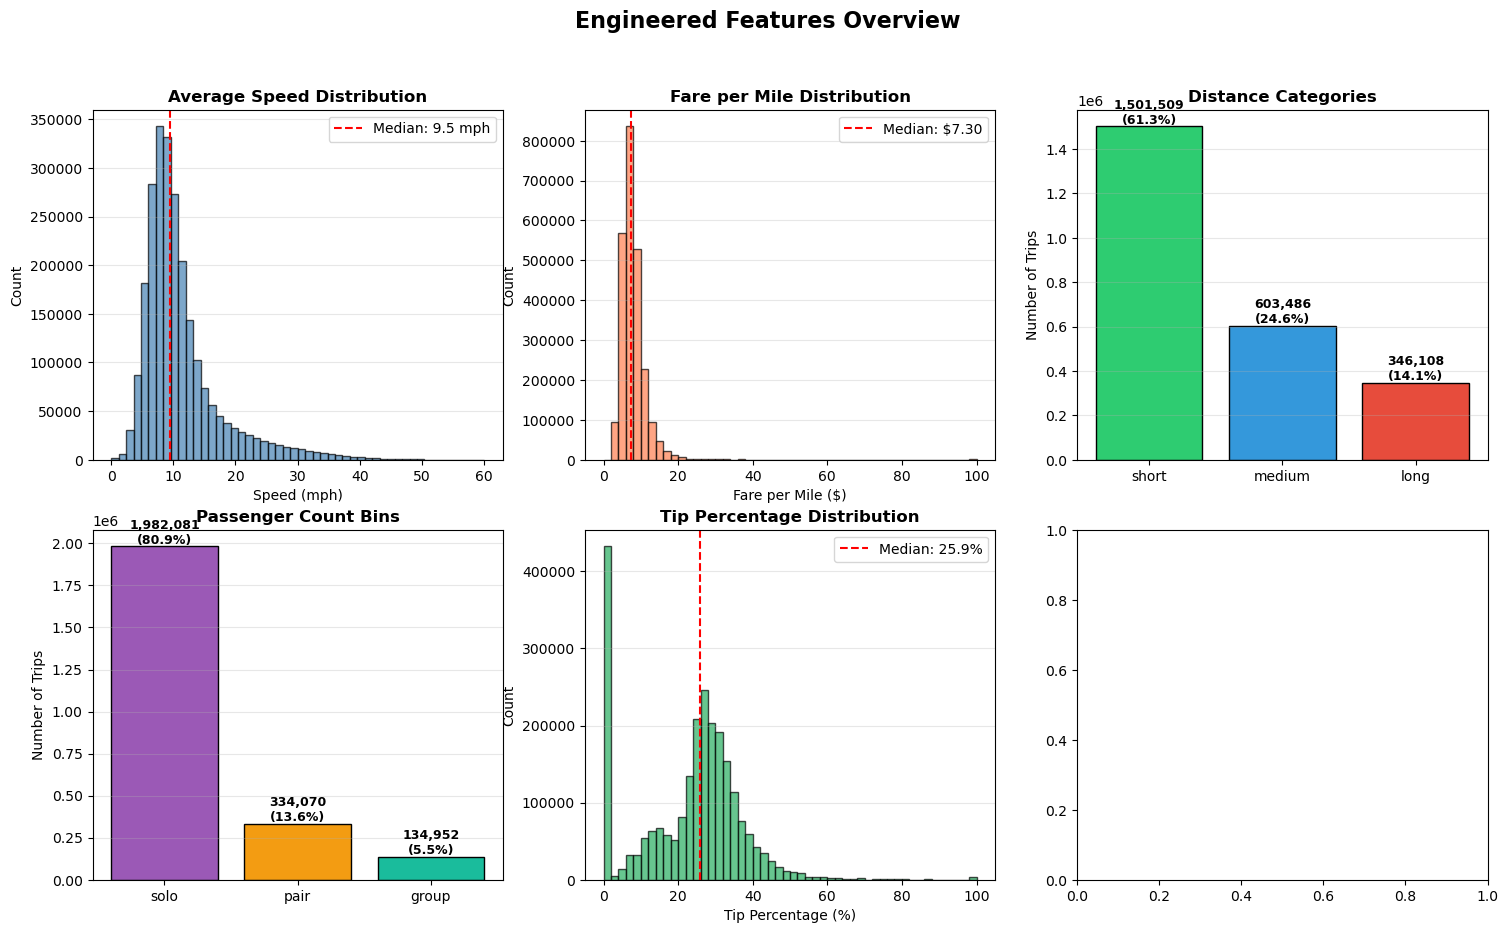

In [12]:
# ============================================
# STEP 8: VISUALIZE NEW FEATURES
# ============================================
print("\n" + "="*70)
print("STEP 8: VISUALIZING NEW FEATURES")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Engineered Features Overview', fontsize=16, fontweight='bold')

# 1. Average speed distribution
axes[0, 0].hist(df['avg_speed_mph'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df['avg_speed_mph'].median(), color='red', linestyle='--',
                    label=f"Median: {df['avg_speed_mph'].median():.1f} mph")
axes[0, 0].set_xlabel('Speed (mph)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Average Speed Distribution', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Fare per mile distribution
axes[0, 1].hist(df['fare_per_mile'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(df['fare_per_mile'].median(), color='red', linestyle='--',
                    label=f"Median: ${df['fare_per_mile'].median():.2f}")
axes[0, 1].set_xlabel('Fare per Mile ($)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Fare per Mile Distribution', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Distance category bar chart
dist_counts = df['distance_category'].value_counts().reindex(['short', 'medium', 'long'])
axes[0, 2].bar(dist_counts.index, dist_counts.values,
               color=['#2ecc71', '#3498db', '#e74c3c'], edgecolor='black')
axes[0, 2].set_ylabel('Number of Trips')
axes[0, 2].set_title('Distance Categories', fontweight='bold')
for i, v in enumerate(dist_counts.values):
    axes[0, 2].text(i, v, f'{v:,}\n({v/len(df)*100:.1f}%)',
                    ha='center', va='bottom', fontweight='bold', fontsize=9)
axes[0, 2].grid(axis='y', alpha=0.3)

# 4. Passenger bins
pax_counts = df['passenger_count_binned'].value_counts().reindex(['solo', 'pair', 'group'])
axes[1, 0].bar(pax_counts.index, pax_counts.values,
               color=['#9b59b6', '#f39c12', '#1abc9c'], edgecolor='black')
axes[1, 0].set_ylabel('Number of Trips')
axes[1, 0].set_title('Passenger Count Bins', fontweight='bold')
for i, v in enumerate(pax_counts.values):
    axes[1, 0].text(i, v, f'{v:,}\n({v/len(df)*100:.1f}%)',
                    ha='center', va='bottom', fontweight='bold', fontsize=9)
axes[1, 0].grid(axis='y', alpha=0.3)

# 5. Tip percentage distribution
axes[1, 1].hist(df['tip_percentage'], bins=50, color='#27ae60', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(df['tip_percentage'].median(), color='red', linestyle='--',
                    label=f"Median: {df['tip_percentage'].median():.1f}%")
axes[1, 1].set_xlabel('Tip Percentage (%)')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Tip Percentage Distribution', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

In [13]:
# 6. Outlier flags summary
outlier_data = {
    'Extreme\nDistance': df['is_extreme_distance'].sum(),
    'Extreme\nFare': df['is_extreme_fare'].sum(),
    'Normal\nTrips': len(df) - max(df['is_extreme_distance'].sum(), df['is_extreme_fare'].sum())
}
axes[1, 2].bar(outlier_data.keys(), outlier_data.values(),
               color=['#e74c3c', '#e67e22', '#2ecc71'], edgecolor='black')
axes[1, 2].set_ylabel('Number of Trips')
axes[1, 2].set_title('Outlier Flags Summary', fontweight='bold')
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [14]:
# ============================================
# STEP 9: SAVE ENGINEERED DATA
# ============================================
print("\n" + "="*70)
print("STEP 9: SAVING ENGINEERED DATASET")
print("="*70)

output_path = r"../../data/processed/taxi_trip_characteristics_features.parquet"
df.to_parquet(output_path, index=False)

print(f"✅ Feature-engineered data saved!")
print(f"   Path: {output_path}")
print(f"   Trips: {len(df):,}")
print(f"   Total columns: {len(df.columns)}")

print(f"\n{'='*70}")
print("✅ FEATURE ENGINEERING COMPLETE!")
print(f"{'='*70}")
print(f"\n📋 Features created:")
print(f"   1. avg_speed_mph        - Speed (analysis only)")
print(f"   2. fare_per_mile        - Fare efficiency (analysis only)")
print(f"   3. total_per_mile       - Fare efficiency (analysis only)")
print(f"   4. is_single_passenger  - Passenger binary flag")
print(f"   5. passenger_count_binned - Passenger category (solo/pair/group)")
print(f"   6. tip_percentage       - Cost ratio (analysis only)")
print(f"   7. tip_to_total_ratio   - Cost ratio (analysis only)")
print(f"   8. distance_category    - Distance bin (short/medium/long)")
print(f"   9. is_extreme_distance  - Outlier flag")
print(f"  10. is_extreme_fare      - Outlier flag")



STEP 9: SAVING ENGINEERED DATASET
✅ Feature-engineered data saved!
   Path: ../../data/processed/taxi_trip_characteristics_features.parquet
   Trips: 2,451,103
   Total columns: 32

✅ FEATURE ENGINEERING COMPLETE!

📋 Features created:
   1. avg_speed_mph        - Speed (analysis only)
   2. fare_per_mile        - Fare efficiency (analysis only)
   3. total_per_mile       - Fare efficiency (analysis only)
   4. is_single_passenger  - Passenger binary flag
   5. passenger_count_binned - Passenger category (solo/pair/group)
   6. tip_percentage       - Cost ratio (analysis only)
   7. tip_to_total_ratio   - Cost ratio (analysis only)
   8. distance_category    - Distance bin (short/medium/long)
   9. is_extreme_distance  - Outlier flag
  10. is_extreme_fare      - Outlier flag
